In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import yt
import ytathena as ya
import const
import radmc
import scipy.ndimage as sn
from  scipy.spatial.distance import pdist
import time
import corefind as cf
import starpar_vtk
def get_extent(grid, axis, unit):
    left_edge = grid.left_edge
    right_edge = grid.right_edge
    if axis == 2:
        xmin = (left_edge[0]/unit).value
        xmax = (right_edge[0]/unit).value
        ymin = (left_edge[1]/unit).value
        ymax = (right_edge[1]/unit).value
    elif axis == 1:
        xmin = (left_edge[0]/unit).value
        xmax = (right_edge[0]/unit).value
        ymin = (left_edge[2]/unit).value
        ymax = (right_edge[2]/unit).value
    elif axis == 0:
        xmin = (left_edge[1]/unit).value
        xmax = (right_edge[1]/unit).value
        ymin = (left_edge[2]/unit).value
        ymax = (right_edge[2]/unit).value
    extent = [float(xmin), float(xmax), float(ymin), float(ymax)]
    return extent

def get_surfd(grid, axis):
    dx = grid["dx"][0, 0, 0]
    surfd = grid["density"].sum(axis=axis)*dx
    surfd_cgs = surfd.in_units("g/cm**2").to_ndarray()
    surfd_N = surfd_cgs / (1.4 * const.mh)
    return surfd_N

def plot_cores(grid, cores, axis=2, sp_fname=None, **key):
    surfd = get_surfd(grid, axis)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(111)
    extent = get_extent(grid, axis, yt.units.kpc)
    cax=ax.imshow(np.swapaxes(surfd, 0, 1), origin="lower",cmap="viridis", extent=extent,
                  **key)
    dx = grid["dx"][0, 0, 0]
    dv = dx*dx*dx
    axis_letters=['x','y','z']
    for i in xrange(len(cores)):
        mcell = (grid["density"]*dv).in_units("Msun").to_ndarray()
        mcore = mcell[cores[i].positions].sum()
        fc = np.zeros(cores[i].field.shape)
        fc[cores[i].positions] = 1
        fc2 = fc.max(axis=axis)
        c_color = "k"
        if mcore > 1:
            c_color = "y"
        if mcore > 1000:
            c_color = "red"
        ax.contour(np.swapaxes(fc2, 0, 1), origin="lower", levels=[0], 
                   colors=[c_color], linewidth=2, extent=extent)
    if sp_fname is not None:
        sp=starpar_vtk.read(sp_fname)
        starpar_vtk.scatter_sp(sp,ax,axis=axis_letters[axis],runaway=True,type='surf', norm_factor=1)
        starpar_vtk.sp_legend(ax, norm_factor=1, top=True)
    fig.colorbar(cax)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim([extent[0], extent[1]])
    ax.set_ylim([extent[2], extent[3]])

ImportError: No module named ytathena

In [2]:
id='MHD_4pc'
stime="%4.4d" % 224
print stime
#MHD_4pc=yt.load('/tigress/changgoo/pleiades/%s/id0/%s.%s.vtk' % (id,id,stime),
#           nprocs=512, units_override=ya.unit_base_pp)

0224


yt : [INFO     ] 2016-09-23 15:21:21,657 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2016-09-23 15:21:21,679 Assuming 1.0 = 1.0 cm
yt : [WARNING  ] 2016-09-23 15:21:21,680 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2016-09-23 15:21:21,681 Assuming 1.0 = 1.0 g
yt : [WARNING  ] 2016-09-23 15:21:21,699 Overriding code units. This is an experimental and potentially dangerous option that may yield inconsistent results, and must be used very carefully, and only if you know what you want from it.
yt : [INFO     ] 2016-09-23 15:21:21,699 Overriding length_unit: 1 cm -> 1 pc.
yt : [INFO     ] 2016-09-23 15:21:21,700 Overriding time_unit: 1 s -> 1 s*pc/km.
yt : [INFO     ] 2016-09-23 15:21:21,702 Overriding mass_unit: 1 g -> 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2016-09-23 15:21:21,722 Parameters: current_time              = 224.0004
yt : [INFO     ] 2016-09-23 15:21:21,723 Parameters: domain_dimensions 

In [3]:
cube = MHD_4pc.covering_grid(level=0, left_edge=[-512,-256,-384],dims=[128,128,128])
phi = -cube["gravitational_potential"].to_ndarray()

In [5]:
#test simple core finding
reload(cf)
cores = cf.find_cores(phi, 0.5)

time=1.50e+02


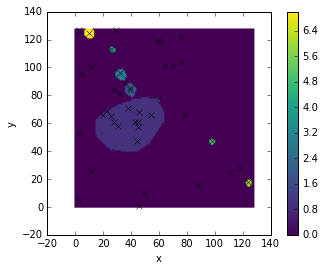

In [7]:
plot_cores(cores)

In [158]:
reload(cf)
f = sn.maximum_filter(phi, size=3)
maxima = phi == f
maxima_map = np.zeros(phi.shape)
maxima_map[maxima] = 1
master_clump = cf.Clump(phi, maxima_map, np.where(phi>0))
master_clump.find_min_val(0.01)

607.72613878011703

In [151]:
labelled_array, nclumps, max_labels=master_clump.get_label(606)
print nclumps, max_labels

1 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1]


In [39]:
mid_plane_MHD_4pc = MHD_4pc.covering_grid(level=0, left_edge=[-512,-512,-256],dims=[256,256,128])
phi_mid_plane_MHD_4pc = -mid_plane_MHD_4pc["gravitational_potential"].to_ndarray()
surfd = get_surfd(mid_plane_MHD_4pc, 2)

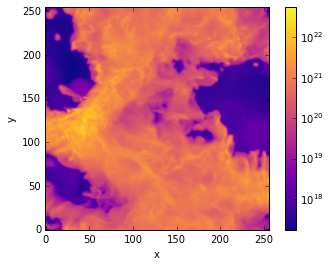

In [111]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax=ax.imshow(np.swapaxes(surfd, 0, 1), origin="lower",cmap="plasma", norm=LogNorm())
fig.colorbar(cax)
ax.set_xlabel("x")
ax.set_ylabel("y")

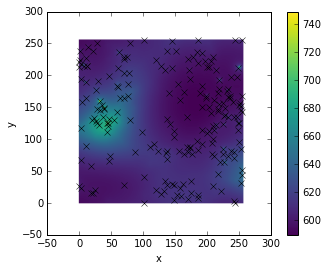

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax=ax.imshow(np.swapaxes(phi_mid_plane_MHD_4pc.max(axis=2), 0, 1), origin="lower",cmap="viridis")
wc = np.where(cores[0].maxima_map > 0)
wc1 = np.transpose(wc)
for wi in wc1:
    ax.plot(wi[0], wi[1], "kx")
fig.colorbar(cax)
ax.set_xlabel("x")
ax.set_ylabel("y")

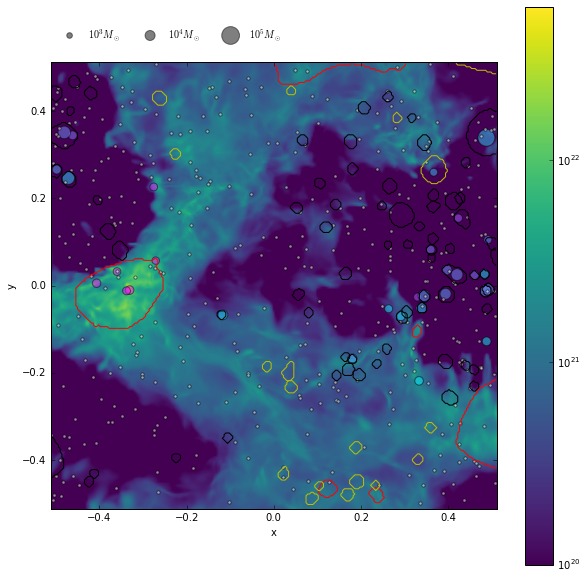

In [137]:
#whole midplane
#reload(cf)
#cores_MHD_4pc = cf.find_cores(phi_mid_plane_MHD_4pc, 0.5)
sp_fname_MHD_4pc = "/tigress/changgoo/pleiades/MHD_4pc/id0/MHD_4pc.0224.starpar.vtk"
plot_cores(mid_plane_MHD_4pc, cores_MHD_4pc, norm=LogNorm(), axis=2, vmin=1e20, sp_fname=sp_fname_MHD_4pc)

find_cores: time spent=1.48e+02 sec


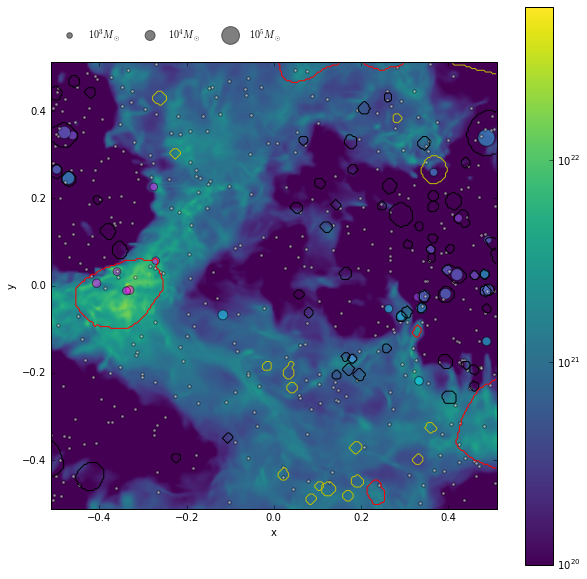

In [153]:
#whole midplane
reload(cf)
cores_MHD_4pc = cf.find_cores(phi_mid_plane_MHD_4pc, 0.5)
sp_fname_MHD_4pc = "/tigress/changgoo/pleiades/MHD_4pc/id0/MHD_4pc.0224.starpar.vtk"
plot_cores(mid_plane_MHD_4pc, cores_MHD_4pc, norm=LogNorm(), axis=2, vmin=1e20, sp_fname=sp_fname_MHD_4pc)

In [ ]:
fn = "/tigress/munan/chemistry/MST_4pc_joined/MST_4pc_midplane.0400.vtk"
ds = yt.load(fn, units_override=ya.unit_base)
grid = ya.get_covering_grid(ds)
phi_MST_4pc = -grid["gravitational_potential"].to_ndarray()
#whole midplane
#cores = cf.find_cores(phi_MST_4pc, 0.5)

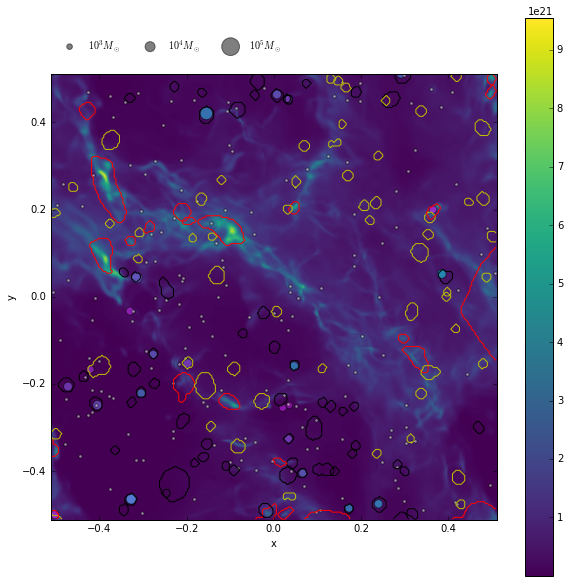

In [139]:
sp_fname_MST_4pc = "/tigress/changgoo/MST_4pc/id0/MST_4pc.0400.starpar.vtk"
plot_cores(grid, cores, sp_fname=sp_fname_MST_4pc, axis=2)

find_cores: time spent=3.91e+02 sec


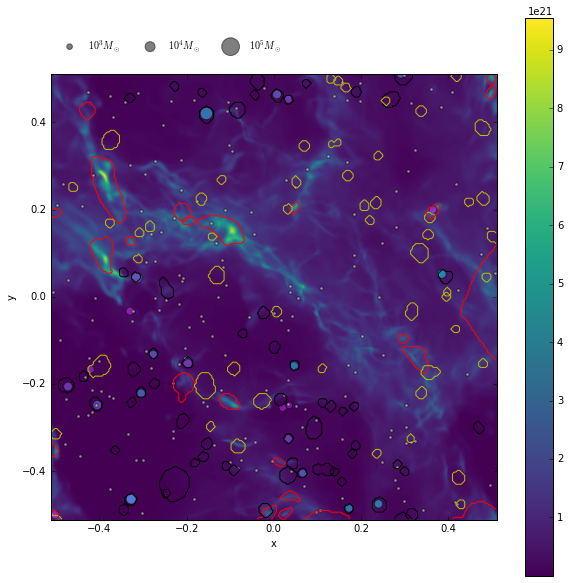

In [165]:
#whole midplane
reload(cf)
cores = cf.find_cores(phi_MST_4pc, 0.1)
sp_fname_MST_4pc = "/tigress/changgoo/MST_4pc/id0/MST_4pc.0400.starpar.vtk"
plot_cores(grid, cores, sp_fname=sp_fname_MST_4pc, axis=2)

find_cores: time spent=2.46e+02 sec


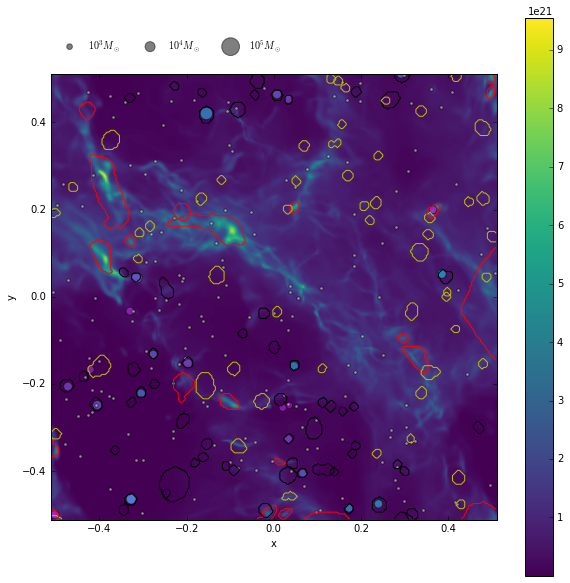

In [166]:
#whole midplane
reload(cf)
cores = cf.find_cores(phi_MST_4pc, 0.2)
sp_fname_MST_4pc = "/tigress/changgoo/MST_4pc/id0/MST_4pc.0400.starpar.vtk"
plot_cores(grid, cores, sp_fname=sp_fname_MST_4pc, axis=2)

find_cores: time spent=3.68e+02 sec


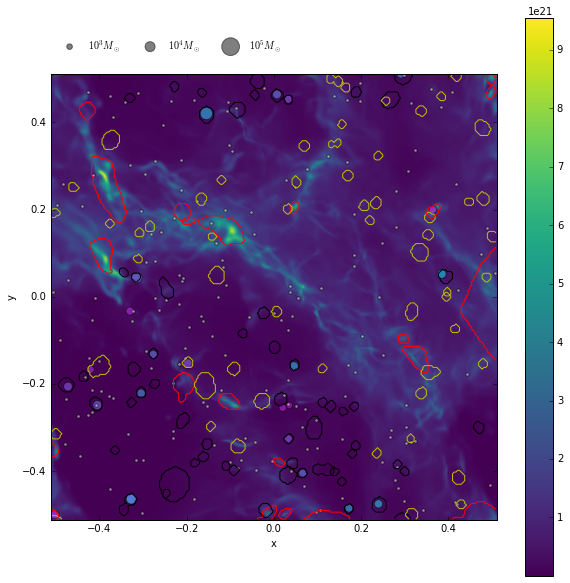

In [167]:
#whole midplane
reload(cf)
cores = cf.find_cores(phi_MST_4pc, 0.1, maxima_size=10)
sp_fname_MST_4pc = "/tigress/changgoo/MST_4pc/id0/MST_4pc.0400.starpar.vtk"
plot_cores(grid, cores, sp_fname=sp_fname_MST_4pc, axis=2)